# test of detector integration idea in 2-dimensions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.signal import convolve
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import fftn, fftshift
from scipy.ndimage import gaussian_filter
%matplotlib widget

In [33]:
def simulator_2D(img, x_mesh, y_mesh):
    x_vals = x_mesh[0,:]
    y_vals = y_mesh[:,0]
    
    # Compute the Fourier transform of the density grid
    ft_density = fftn(img)
    ft_density_shifted = fftshift(ft_density)  # Shift the zero-frequency component to the center of the spectrum

    # Calculate 3D q-values
    qx = np.fft.fftfreq(len(x_vals), d=x_vals[1]-x_vals[0]) * 2 * np.pi
    qy = np.fft.fftfreq(len(y_vals), d=y_vals[1]-y_vals[0]) * 2 * np.pi
    qx_shifted = fftshift(qx)
    qy_shifted = fftshift(qy)
    qx_mesh, qy_mesh = np.meshgrid(qx_shifted, qy_shifted)
    
    # Magnitude squared of the Fourier transform for scattering intensity I(q)
    iq = np.abs(ft_density_shifted)**2

    return qx_mesh, qy_mesh, iq


def detector_integration_2D(r_img, r_x_mesh, r_y_mesh, det_angle, num_pixels):
    """
        This function simulates the integration of a 2D image along a line
        representing a detector at a specified angle, and then plots both the
        original image with the line overlay and a 1D integration along that line.
    
        Parameters:
        - r_img (numpy.ndarray): The 2D array representing the reciprocal space image to be integrated.
        - r_x_mesh (numpy.ndarray): A 2D array representing the reciprocal space x-coordinates at each point of the img.
        - r_y_mesh (numpy.ndarray): A 2D array representing the reciprocal space y-coordinates at each point of the img.
        - det_angle (float): The angle of the detector line with respect to the x-axis, in degrees.
        - num_pixels (int): The number of points along the detector line for which the integration
          is evaluated.
    
        Returns:
        - line_axis_vals (numpy.ndarray): A 1D array of length 'num_pixels' 
          representing the positions along the detector line.
        - line_vals (numpy.ndarray): A 1D array of the same length as 'line_axis_vals', 
          representing the integrated values of 'img' along the detector line.
        """
    fig, (ax1, ax2) = subplots(1,2)
    x_vals = r_x_mesh[0,:]
    y_vals = r_y_mesh[:,0]
    
    ax1.imshow(r_img,
               norm=matplotlib.colors.LogNorm(vmin=np.percentile(r_img,50),
                                              vmax = np.percentile(r_img,99.5)),
               extent=(np.min(x_vals),np.max(x_vals),np.min(y_vals),np.max(y_vals)),
               cmap='turbo',
               origin = 'lower')
    ax1.set_xlabel('x-length units')
    ax1.set_ylabel('y-length units')
    ax1.set_title('dummy reciprocal space 2D map\nred line="detector"')
    
    #find maximum length of line within the rectangle for given theta 
    theta = np.radians(det_angle)
    
    # periodicity for every theta=pi
    theta_new = np.abs(theta)%np.pi
    
    #symmetry about theta=pi/2
    neg_flag = False
    if theta_new > np.pi/2:
        neg_flag = True
        theta_new = np.pi - theta_new
    if theta_new <= np.arctan(np.max(y_vals)/np.max(x_vals)):
        line_max = np.max(x_vals)/np.cos(theta_new)
    if theta_new > np.arctan(np.max(y_vals)/np.max(x_vals)):
        line_max = np.max(y_vals)/np.sin(theta_new)

    
    #calculate detector line values in new axis, x axis, and y axis
    line_axis_vals = np.linspace(-line_max,line_max, num_pixels)
    line_x_axis_vals = line_axis_vals*np.cos(theta_new)
    if neg_flag:
        line_x_axis_vals *= -1
    line_y_axis_vals = line_axis_vals*np.sin(theta_new)
    
    # plot the line on the image
    ax1.plot(line_x_axis_vals, line_y_axis_vals, 'r-', linewidth=2)  # Red line
    
    line_vals = np.zeros_like(line_axis_vals)
    for i in range(num_pixels):
        x_idx = np.argmin(np.abs(x_vals-line_x_axis_vals[i]))
        y_idx = np.argmin(np.abs(y_vals-line_y_axis_vals[i]))
        line_vals[i] = r_img[y_idx, x_idx]

    ax2.plot(line_axis_vals, line_vals)
    ax2.set_xlabel('detector length units')
    ax2.set_ylabel('image value (radius)')
    ax2.set_yscale('log')
    plt.tight_layout()

    return line_axis_vals, line_vals

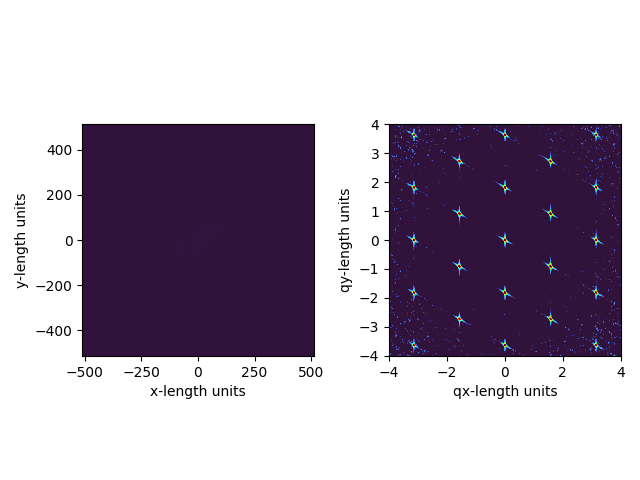

In [54]:
# number of points along x and y axis for rectangle
x_num = 5000
y_num = 5000

# maximum absolute value in length units for rectangle centered on origin
x_max = 512
y_max = 512

#length values for each pixel of rectangle
x_vals = np.linspace(-x_max,x_max, x_num)
y_vals = np.linspace(-y_max,y_max, y_num)

#create meshgrids and dummy image
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)

# Lattice constant
a = 4  # you can adjust this value

# disorder constant
# non-cumulative disorder:
# each point is nudged from its lattice point by displacement
disorder_sigma = a*0.05 #describes sigma for displacement probability (Å)

#number of repeats
rep = 20

# Lattice vectors
a1 = np.array([1, 0]) * a
a2 = np.array([0.5, np.sqrt(3)/2]) * a

# Initialize the density array
density_map = np.zeros_like(x_mesh)

# Place intensity at lattice points
for i in range(-rep, rep+1):  # Adjust range as needed for lattice size
    for j in range(-rep, rep+1):
        lattice_point = i * a1 + j * a2
        random_disp = np.random.normal(loc=0.0, scale=1.0, size=2)
        random_disp *= disorder_sigma
        lattice_point[0]+=random_disp[0]
        lattice_point[1]+=random_disp[1]
        # Find the closest index in the meshgrid
        ix = np.argmin(np.abs(x_vals - lattice_point[0]))
        iy = np.argmin(np.abs(y_vals - lattice_point[1]))
        density_map[iy, ix] = 1  # Assign intensity

# Convolve with a Gaussian kernel
sigma = 0  # Standard deviation for Gaussian kernel
img = gaussian_filter(density_map, sigma=sigma)

#find FFT of image
qx_mesh, qy_mesh, q_img = simulator_2D(img, x_mesh, y_mesh)

qx_vals = qx_mesh[0,:]
qy_vals = qy_mesh[:,0]

fig, (ax1, ax2) = subplots(1,2)
img_min = np.percentile(img, 50)
img_max = np.percentile(img, 99.999)
ax1.imshow(img,
           norm=matplotlib.colors.Normalize(vmin = img_min, vmax = img_max),
           extent=(np.min(x_vals),np.max(x_vals),np.min(y_vals),np.max(y_vals)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('x-length units')
ax1.set_ylabel('y-length units')

q_img[q_img<=0]=1e-10
img_min = np.percentile(q_img, 70)
img_max = np.percentile(q_img, 99.99)
ax2.imshow(q_img,
           norm=matplotlib.colors.LogNorm(vmin = img_min, vmax = img_max),
           extent=(np.min(qx_vals),np.max(qx_vals),np.min(qy_vals),np.max(qy_vals)),
           cmap='turbo',
           origin = 'lower')
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
ax2.set_xlabel('qx-length units')
ax2.set_ylabel('qy-length units')
plt.tight_layout()

In [40]:
plt.close('all')

In [49]:
ax1.imshow(img,
           norm=matplotlib.colors.LogNorm(vmin=0.0003, vmax=0.15),
           extent=(np.min(x_vals),np.max(x_vals),np.min(y_vals),np.max(y_vals)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('x-length units')
ax1.set_ylabel('y-length units')

# img_min = np.log(np.percentile(q_img, 90))
# img_max = np.log(np.percentile(q_img, 99.995))
# ax2.imshow(np.log(q_img),
#            norm=matplotlib.colors.Normalize(vmin = img_min, vmax = img_max),
#            extent=(np.min(qx_vals),np.max(qx_vals),np.min(qy_vals),np.max(qy_vals)),
#            cmap='turbo',
#            origin = 'lower')
# ax2.set_xlim(-4,4)
# ax2.set_ylim(-4,4)
# ax2.set_xlabel('qx-length units')
# ax2.set_ylabel('qy-length units')
# plt.tight_layout()

Text(29.0, 0.5, 'y-length units')

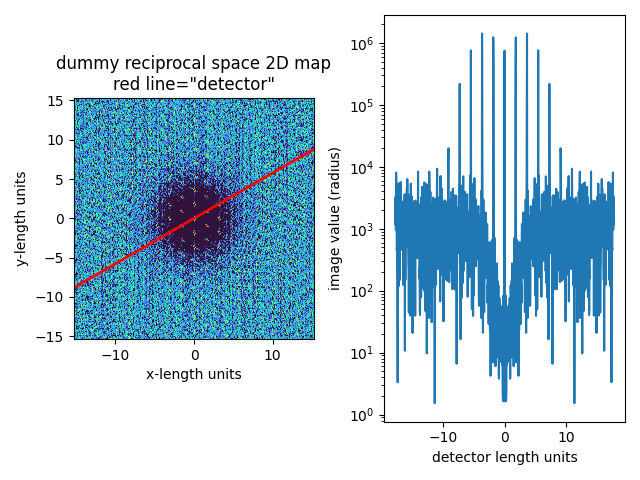

In [55]:
#details for detector line
num_pixels = 1000
det_angle = 30

x_vals, y_vals = detector_integration_2D(q_img, qx_mesh, qy_mesh, det_angle, num_pixels)